In [1]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

In [2]:
# It is important to do data augmentation in training.
image_size = 128

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((image_size, image_size)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 0.7)),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.

test_tfm = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [3]:
# A greater batch size usually gives a more stable gradient.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("image/train/", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("image/validate", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("image/test", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

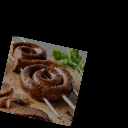

In [4]:
transforms.ToPILImage()(train_set[0][0])

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 64, 64]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),

            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),

        )
        self.fc_layers = nn.Sequential(
            nn.Linear(3136, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )
        
    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device


#Read trained model you saved
#model = Classifier().to(device)
#model.load_state_dict(torch.load("model.ckpt", map_location=lambda storage, loc: storage))
#model.device = device


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='max',
                                                        factor=0.6,
                                                        patience=3,
                                                        verbose=True,
                                                        threshold=1e-3)

n_epochs = 12
model_path = "model.ckpt"


best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []
early_stop = 0
record = {'train_acc':[], 'train_loss':[], 'test_acc':[], 'test_loss':[]}

for epoch in range(n_epochs):
    # ---------- Train ----------
    model.train()

    train_loss = []
    train_accs = []

    # for batch in tqdm(train_loader):
    for batch in train_loader:
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    record['train_acc'].append(train_acc)
    record['train_loss'].append(train_loss)
    print(f"[ Train | {epoch + 1:03d} / {n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    model.eval()

    valid_loss = []
    valid_accs = []

    # for batch in tqdm(valid_loader):
    for batch in valid_loader:
        imgs, labels = batch

        with torch.no_grad():
            logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)
    
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    record['test_loss'].append(valid_loss)
    record['test_acc'].append(valid_acc)
    scheduler.step(valid_acc)
    print(f"[ Valid | {epoch + 1:03d} / {n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # ---------- Record ----------
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('model save with accuracy and epoch', best_acc, epoch+1)
        torch.save(model.state_dict(), model_path)
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc)
    valid_acc_record.append(valid_acc)
    
    if train_acc > valid_acc * 1.1:
        early_stop += 1
    if early_stop == 10:
        break

[ Train | 001 / 012 ] loss = 1.52029, acc = 0.25313
[ Valid | 001 / 012 ] loss = 1.40576, acc = 0.23706
model save with accuracy and epoch tensor(0.2371) 1
[ Train | 002 / 012 ] loss = 1.44269, acc = 0.24719
[ Valid | 002 / 012 ] loss = 1.40679, acc = 0.21422
[ Train | 003 / 012 ] loss = 1.43753, acc = 0.26031
[ Valid | 003 / 012 ] loss = 1.39703, acc = 0.24579
model save with accuracy and epoch tensor(0.2458) 3
[ Train | 004 / 012 ] loss = 1.42267, acc = 0.25875
[ Valid | 004 / 012 ] loss = 1.43210, acc = 0.28630
model save with accuracy and epoch tensor(0.2863) 4
[ Train | 005 / 012 ] loss = 1.41721, acc = 0.25281
[ Valid | 005 / 012 ] loss = 1.40497, acc = 0.28113
[ Train | 006 / 012 ] loss = 1.41901, acc = 0.24078
[ Valid | 006 / 012 ] loss = 1.40306, acc = 0.25925
[ Train | 007 / 012 ] loss = 1.40853, acc = 0.25438
[ Valid | 007 / 012 ] loss = 1.39865, acc = 0.27151
[ Train | 008 / 012 ] loss = 1.41271, acc = 0.25391
Epoch 00008: reducing learning rate of group 0 to 2.4000e-03.
[ 

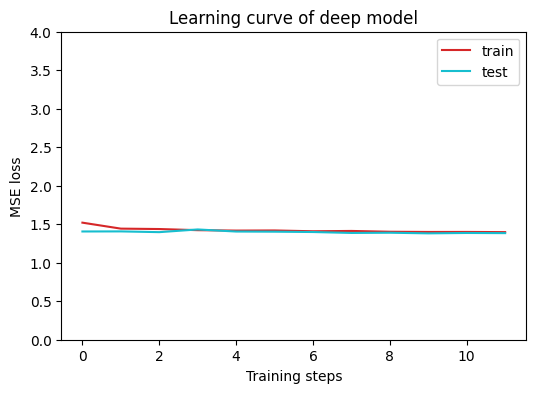

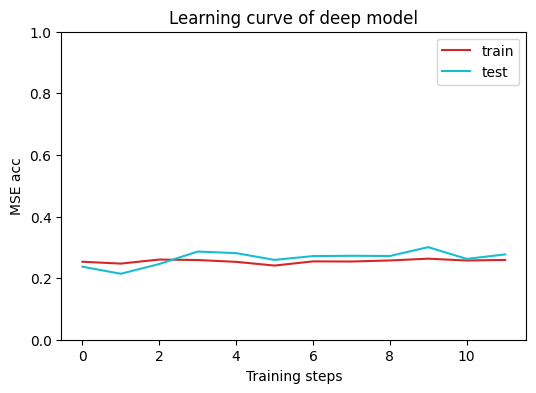

In [7]:
def plot_learning_curve(loss_record, ymax, ymin, typ='', title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record[f'train_{typ}'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record[f'train_{typ}']) // len(loss_record[f'test_{typ}'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record[f'train_{typ}'], c='tab:red', label='train')
    plt.plot(x_2, loss_record[f'test_{typ}'], c='tab:cyan', label='test')
    plt.ylim([0 if ymin < 0 else ymin][0], ymax)
    plt.xlabel('Training steps')
    plt.ylabel(f'MSE {typ}')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
ymax = math.ceil(record['train_loss'][int(len(record['train_loss'])/2)] + 2)
ymin = math.floor(record['train_loss'][int(len(record['train_loss'])/2)] - 2)
plot_learning_curve(record, ymax, ymin, typ='loss', title='deep model')

#ymax = math.ceil(record['test_acc'][int(len(record['test_acc'])/2)] + 2)
#ymin = math.floor(record['test_acc'][int(len(record['test_acc'])/2)] - 2)
plot_learning_curve(record, 1, 0, typ='acc', title='deep model')

In [8]:
#model = Classifier().to(device)
model.load_state_dict(torch.load("model.ckpt", map_location=lambda storage, loc: storage))
model.device = device
model.eval()

predictions = []

try:
    for batch in test_loader:
        imgs, labels = batch

        with torch.no_grad():
            logits = model(imgs.to(device))

        predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
except:
    pass

In [10]:
# Load the saved model
from sklearn.metrics import confusion_matrix
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Make predictions on the test set
y_true = []
y_pred = []
try: 
    for batch in test_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        preds = logits.argmax(dim=-1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
except:
    pass

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[187  23  57  48]
 [130  56  89  40]
 [157  29  90  39]
 [158  48  74  35]]


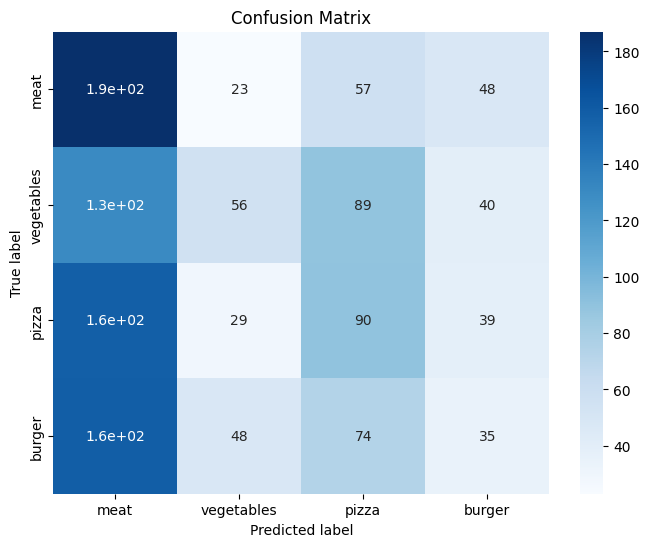

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class names
class_names = ['meat', 'vegetables', 'pizza', 'burger']

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)

# Add labels and title
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.show()

In [9]:
with open("predict.csv", "w") as f:
    f.write("Id,Category\n")

    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")